In [1]:
import os
import csv
import time
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from tqdm import tqdm
from pathlib import Path
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from statannotations.Annotator import Annotator

In [3]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Volumes/Aidan_NYGC/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))

### 4b: AAR and celltype compositions of each region (fixed timepoint)

In [4]:
# Groups cells of same morphological type together
sntypes_map = {
    'Colonocyte': ['Colonocyte'],
    'Immune': ['B', 'T'],
    'Interstitial': ['Fibroblast', 'Glia', 'Lymphatic', 'Macrophage', 'Mesothelial', 'Neuron', 'Vascular'],
    'Muscle': ['SMC'],
    'Epithelial': ['Cycling', 'Enteroendocrine', 'Goblet', 'Stem', 'TA', 'Tuft']
}
sntypes_ordered = (sntypes_map['Immune'] + sntypes_map['Interstitial'] + 
                   sntypes_map['Muscle'] + sntypes_map['Epithelial'] + sntypes_map['Colonocyte'])

# Set colors for each snRNA-seq cell type, ensuring that those sharing a morphological type 
# are drawn from the same colormap.
colors_ordered = []
for snt in sntypes_ordered:
    if snt == 'Colonocyte':
        cmap = matplotlib.cm.get_cmap('Blues')
        colors_ordered.append(cmap(0.75))
    elif snt == 'SMC':
        cmap = matplotlib.cm.get_cmap('Reds')
        colors_ordered.append(cmap(0.75))
    elif snt == 'B' or snt == 'T':
        cmap = matplotlib.cm.get_cmap('Oranges')
        colors_ordered.append(cmap(0.5 * (sntypes_map['Immune'].index(snt)+1) / len(sntypes_map['Immune'])))
    elif snt in sntypes_map['Interstitial']:
        cmap = matplotlib.cm.get_cmap('Greens')
        colors_ordered.append(
            cmap(0.75 * (sntypes_map['Interstitial'].index(snt)+1) / len(sntypes_map['Interstitial'])))
    elif snt in sntypes_map['Epithelial']:
        cmap = matplotlib.cm.get_cmap('Purples')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Epithelial'].index(snt)+1) / len(sntypes_map['Epithelial'])))
    else:
        raise ValueError('Unrecognized cell type')

/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/3944285255.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/3944285255.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greens')
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/3944285255.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplo

In [5]:
age = '12w'
obs = adata.obs[adata.obs.Age==age].copy()

region_list = obs['Region'].unique()
aar_list = ['externa', 'externa and interna', 'interna', 'interna and mucosae', 'muscle and submucosa', 
            'epithelium and mucosae', 'epithelium and mucosae and submucosa',  'epithelium and muscle and submucosa',
            'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex', 'cross-mucosa', "peyer's patch"]

# Add column to obs indicating ST array
obs['array'] = [Path(c).name.split('_stdata')[0] for c in obs.index]

N_REGION = len(region_list)
N_AAR = len(aar_list)
N_CELLTYPE = len(sntypes_ordered)

Characterize abundance of each cell type in each AAR of proximal, middle, distal at single time point

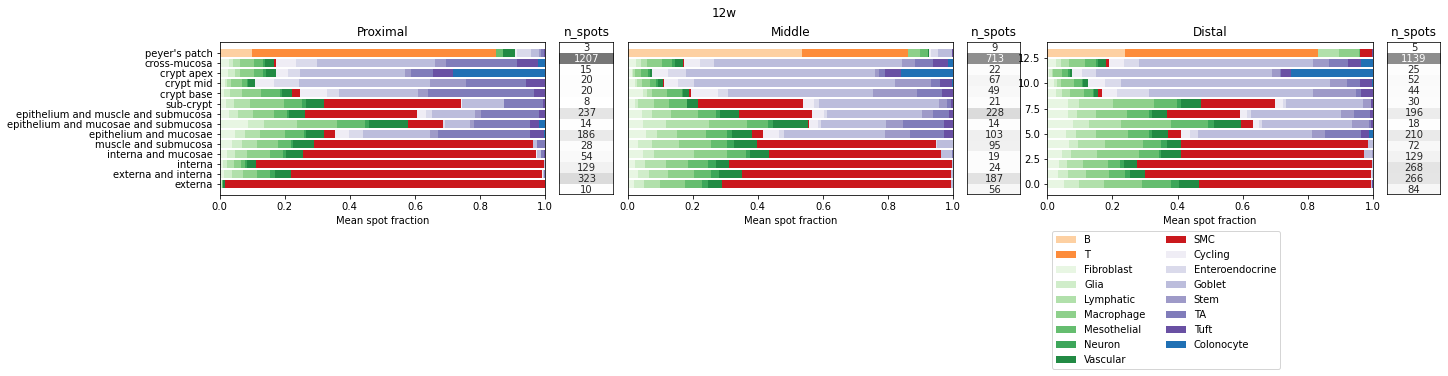

In [11]:
fig, ax = plt.subplots(1, N_REGION*2, figsize=(20, 5), gridspec_kw={'width_ratios': [6,1]*N_REGION}, 
                       constrained_layout=True)

for k, reg in enumerate(region_list):
    avg_comp_celltype = np.zeros((N_AAR, N_CELLTYPE))
    obs_reg = obs[obs['Region']==reg]
    
    for a, aar in enumerate(aar_list):
        for c, ctype in enumerate(sntypes_ordered):
            avg_comp_celltype[a, c] = obs_reg[obs_reg['annotation']==aar][ctype].mean()
    
    for c, ctype in enumerate(sntypes_ordered):
        if c==0:
            ax[2*k].barh(np.arange(N_AAR), avg_comp_celltype[:, c], label=ctype, 
                       color=colors_ordered[c])
        else:
            ax[2*k].barh(np.arange(N_AAR), avg_comp_celltype[:, c], label=ctype, 
                       left=avg_comp_celltype[:, :c].sum(axis=1), color=colors_ordered[c])
    
    # Note number of spots per age, AAR as a heatmap to the side of each plot
    counts_per_aar = np.expand_dims(np.array([np.sum(obs_reg['annotation']==aar) for aar in aar_list], dtype=int), 1)
    normcounts_per_aar = counts_per_aar / counts_per_aar.sum()
    
    #ax[2*k].sharey(ax[2*k+1])
    
    sns.heatmap(data=normcounts_per_aar, ax=ax[2*k+1], annot=counts_per_aar, 
                cmap='binary', fmt='g', vmin=0, vmax=1, cbar=False)
    # draw black border around 1d heatmap
    ax[2*k+1].axvline(0, c='k')
    ax[2*k+1].axvline(1, c='k')
    ax[2*k+1].axhline(0, c='k')
    ax[2*k+1].axhline(len(aar_list), c='k')
    
    ax[2*k+1].invert_yaxis()
    ax[2*k+1].set_xticks([])
    ax[2*k+1].set_yticks([])
    ax[2*k+1].set_title('n_spots')
    
    if k==0:
        ax[k].set_yticks(np.arange(N_AAR))
        ax[k].set_yticklabels(aar_list)
    else:
        ax[k].set_yticks([])
    
    ax[2*k].set_title(reg)
    ax[2*k].set_xlabel('Mean spot fraction')

ax[2*k].legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)

fig.suptitle(age)
plt.show()

### Fig 4d: significant changes in MROI composition across colon regions

In [6]:
from skimage.measure import label
from skimage.morphology import binary_dilation, closing
from scipy.stats import ttest_ind


# Label unique tissues, so that we can treat each one as an independent data point for cell composition.
def label_tissues(obs, xdim=33, ydim=35):
    obs['tissue_id'] = 0
    
    for arr in obs.array.unique():
        inds = obs.index[obs.array == arr]
        xarr = np.rint(obs.x[obs.array == arr].values)
        yarr = np.rint(obs.y[obs.array == arr].values)
        tarr = []
        
        lbl_arr = np.zeros((xdim, ydim), dtype=int)
        for x,y in zip(xarr, yarr):
            lbl_arr[int(x),int(y)] = 1
        
        # Binary dilation (to close tissue gaps) followed by connected component labeling
        lbl_img = label(binary_dilation(lbl_arr))
        
        tarr = [lbl_img[int(x),int(y)]+np.max(obs['tissue_id']) for x,y in zip(xarr,yarr)]
        obs.tissue_id[inds] = tarr
    
    return obs

obs = label_tissues(obs)

print('%d tissues across %d arrays' % (len(obs.tissue_id.unique()), len(obs.array.unique())))

122 tissues across 33 arrays


/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/4147197549.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs.tissue_id[inds] = tarr
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/4147197549.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs.tissue_id[inds] = tarr
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_75609/4147197549.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
def boxplot_significance(obs, abundance_thresh=0.05):
    df_plot = pd.DataFrame(columns=['celltype', 'fraction', 'region'])
    pairs = []
    xlabels = []

    for ct in sntypes_ordered:
        if obs[ct].mean() > abundance_thresh:
            #print(ct)

            xlabels.append(ct)
            ct_means = {}

            for reg in ['Proximal', 'Middle', 'Distal']:
                obs_reg = obs[obs.Region == reg]

                # Find mean abundance of given cell type on each tissue
                tissue_ids = obs_reg.tissue_id.unique()
                ct_means[reg] = [obs_reg.loc[obs_reg.tissue_id == t_id, ct].mean() for t_id in tissue_ids]

                df = pd.DataFrame({
                    'fraction': ct_means[reg],
                    'region': reg,
                    'celltype': ct
                })
                df_plot = pd.concat([df_plot, df])

            pairs.append([(ct, 'Proximal'), (ct, 'Middle')])
            pairs.append([(ct, 'Proximal'), (ct, 'Distal')])
            pairs.append([(ct, 'Middle'), (ct, 'Distal')])

    fig, ax = plt.subplots(1, figsize=(8 * len(xlabels)/5, 6))
    plot_params = {'data': df_plot, 'hue':'region', 'x':'celltype', 'y':'fraction',
                   'order': xlabels, 'hue_order': ['Proximal', 'Middle', 'Distal']}

    ax = sns.boxplot(**plot_params, ax=ax)
    
    ymin, ymax = ax.get_ylim()
    if ymax < 1:
        ax.set_ylim(0,1)
    else:
        ax.set_ylim(0,ymax)

    # Add significance annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test="t-test_welch", comparisons_correction="BH")
    annotator._pvalue_format.pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, ""]]
    annotator.apply_and_annotate()
    #annotator.configure(test="t-test_welch").apply_and_annotate()

    #print(annotator.get_configuration()["pvalue_format"])
    
    return fig, ax

p-value annotation legend:
        : 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophage_Middle vs. Macrophage_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:7.997e-01 t=2.547e-01
Mesothelial_Proximal vs. Mesothelial_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:2.259e-01 t=-1.220e+00
Mesothelial_Middle vs. Mesothelial_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:6.162e-01 t=-5.034e-01
Vascular_Proximal vs. Vascular_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.002e-01 t=1.044e+00
Vascular_Middle vs. Vascular_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:5.543e-01 t=5.943e-01
Cycling_Proximal vs. Cycling_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction

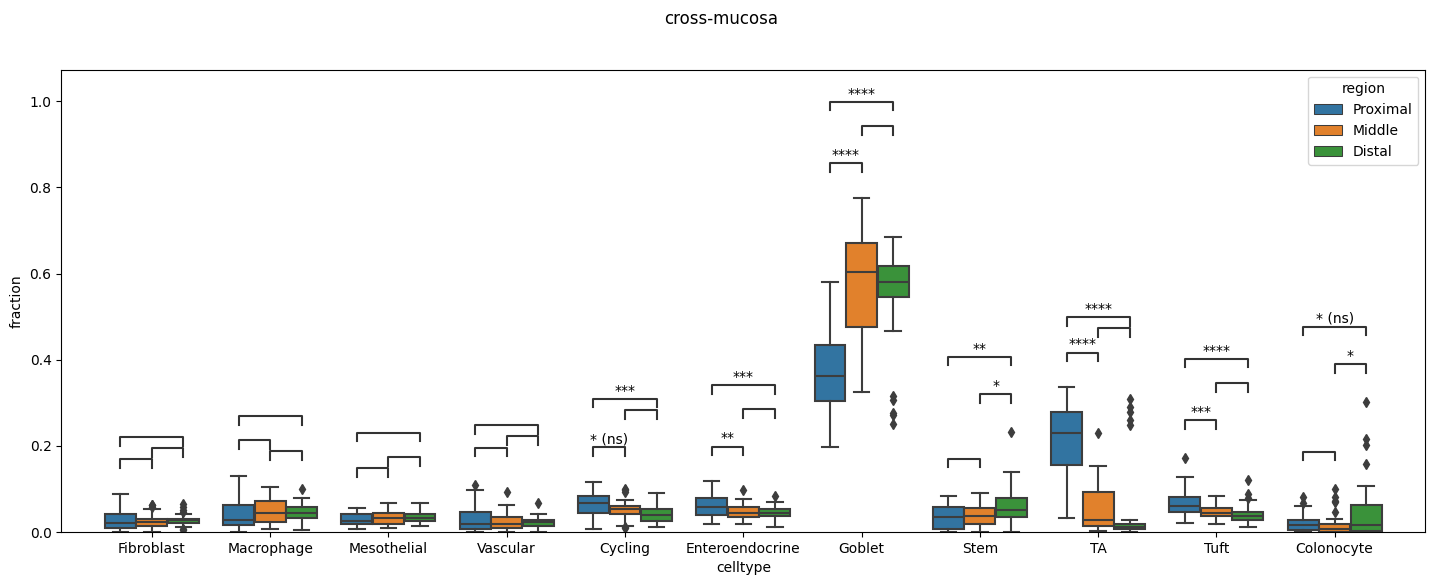

p-value annotation legend:
        : 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mesothelial_Middle vs. Mesothelial_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:7.098e-01 t=3.767e-01
Cycling_Proximal vs. Cycling_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.275e-01 t=-1.006e+00
Cycling_Middle vs. Cycling_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:4.616e-01 t=7.508e-01
Enteroendocrine_Proximal vs. Enteroendocrine_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:2.903e-01 t=-1.094e+00
Enteroendocrine_Middle vs. Enteroendocrine_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:2.706e-01 t=1.130e+00
Goblet_Proximal vs. Goblet_Middle: Welch's t-test independent samples with Benjamini-Hochber

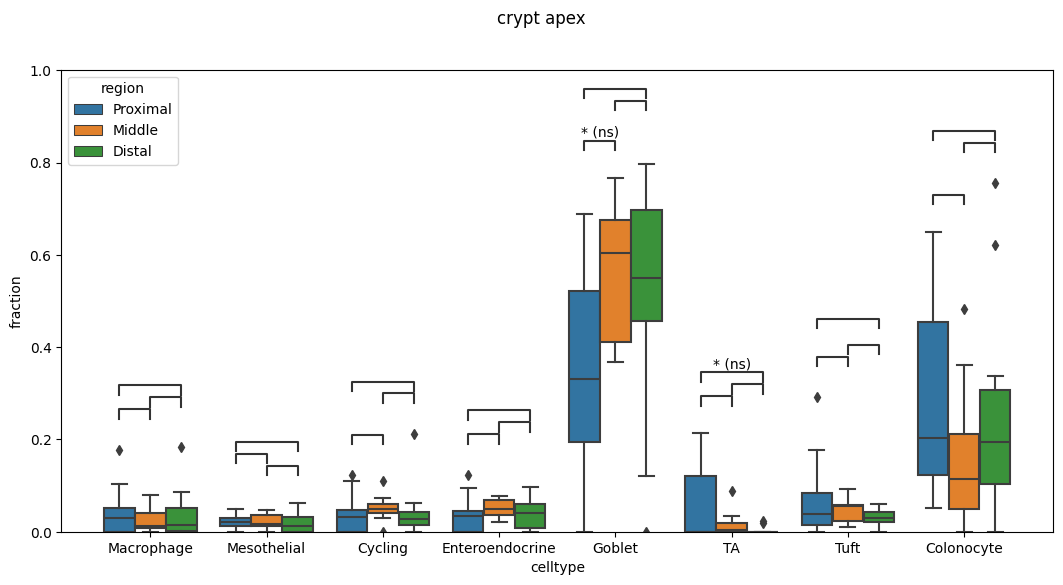

p-value annotation legend:
        : 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Lymphatic_Middle vs. Lymphatic_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:4.291e-01 t=-8.001e-01
Macrophage_Proximal vs. Macrophage_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:4.038e-01 t=8.597e-01
Macrophage_Middle vs. Macrophage_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.655e-01 t=-9.158e-01
Mesothelial_Proximal vs. Mesothelial_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:2.461e-01 t=1.212e+00
Mesothelial_Middle vs. Mesothelial_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:2.628e-01 t=1.136e+00
Cycling_Proximal vs. Cycling_Middle: Welch's t-test independent samples with Benjamini-Hochberg corr

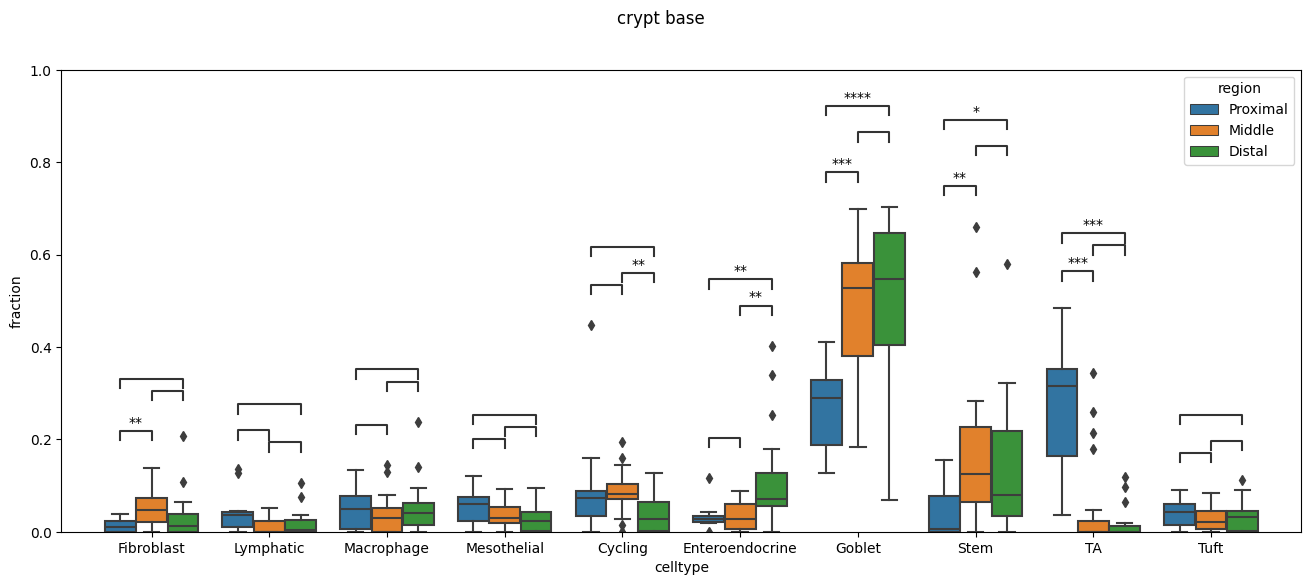

p-value annotation legend:
        : 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glia_Middle vs. Glia_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.830e-01 t=8.776e-01
Lymphatic_Proximal vs. Lymphatic_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.045e-04 t=-3.799e+00
Lymphatic_Middle vs. Lymphatic_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:9.046e-01 t=1.203e-01
Macrophage_Proximal vs. Macrophage_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.478e-04 t=-3.758e+00
Macrophage_Middle vs. Macrophage_Distal: Welch's t-test independent samples with Benjamini-Hochberg correction, P_val:3.225e-01 t=9.959e-01
Mesothelial_Proximal vs. Mesothelial_Middle: Welch's t-test independent samples with Benjamini-Hochberg correction, P_

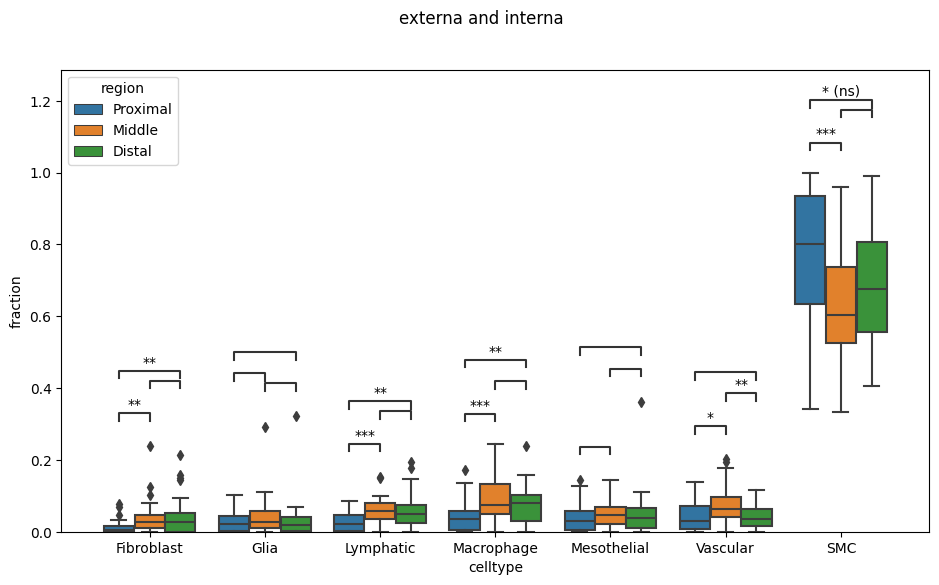

In [31]:
for mroi in ['cross-mucosa', 'crypt apex', 'crypt base', 'externa and interna']:   
    obs_spotlight_mkr_mroi = obs[obs.annotation == mroi]
    
    obs_spotlight_mrk_mroi = obs_spotlight_mkr_mroi[obs_spotlight_mkr_mroi.Age == '12w']
    fig, ax = boxplot_significance(obs_spotlight_mkr_mroi, abundance_thresh=0.02)
    plt.suptitle(mroi)
    plt.savefig('fig3d_sigchanges_%s.svg' % (mroi.replace(' ', '_')))
    plt.show()